In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [5]:
data_dir = '/content/drive/MyDrive/Image '  # folder with A-Z image subfolders


In [6]:
input_folder = data_dir
output_folder = '/content/drive/MyDrive/resized_Image'

os.makedirs(output_folder, exist_ok=True)

for subfolder in os.listdir(input_folder):
    sub_path = os.path.join(input_folder, subfolder)
    out_path = os.path.join(output_folder, subfolder)
    os.makedirs(out_path, exist_ok=True)

    for file in os.listdir(sub_path):
        if file.endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(os.path.join(sub_path, file))
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (64, 64))
            cv2.imwrite(os.path.join(out_path, file), resized)


KeyboardInterrupt: 

In [7]:
X = []
y = []

for folder in os.listdir(output_folder):
    folder_path = os.path.join(output_folder, folder)
    for file in os.listdir(folder_path):
        if file.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img / 255.0
            X.append(img)
            y.append(folder)

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (806, 64, 64), y shape: (806,)


In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (644, 64, 64, 1)
Test shape: (162, 64, 64, 1)


In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,978 (2.62 MB)

 Trainable params: 685,978 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=80,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.0393 - loss: 3.2676 - val_accuracy: 0.0309 - val_loss: 3.2629
Epoch 2/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.0465 - loss: 3.2583 - val_accuracy: 0.0247 - val_loss: 3.2662
Epoch 3/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.0632 - loss: 3.2560 - val_accuracy: 0.0247 - val_loss: 3.2653
Epoch 4/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.0591 - loss: 3.2563 - val_accuracy: 0.0309 - val_loss: 3.2619
Epoch 5/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.0444 - loss: 3.2568 - val_accuracy: 0.0556 - val_loss: 3.2658
Epoch 6/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.0466 - loss: 3.2550 - val_accuracy: 0.0247 - val_loss: 3.2622
Epoch 7/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.0473 - loss: 3.2435 - val_accuracy: 0.1049 - val_loss: 3.2420
Epoch 8/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.0833 - loss: 3.2125 - val_accuracy: 0.

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9693 - loss: 0.1650
Test Accuracy: 0.9753


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


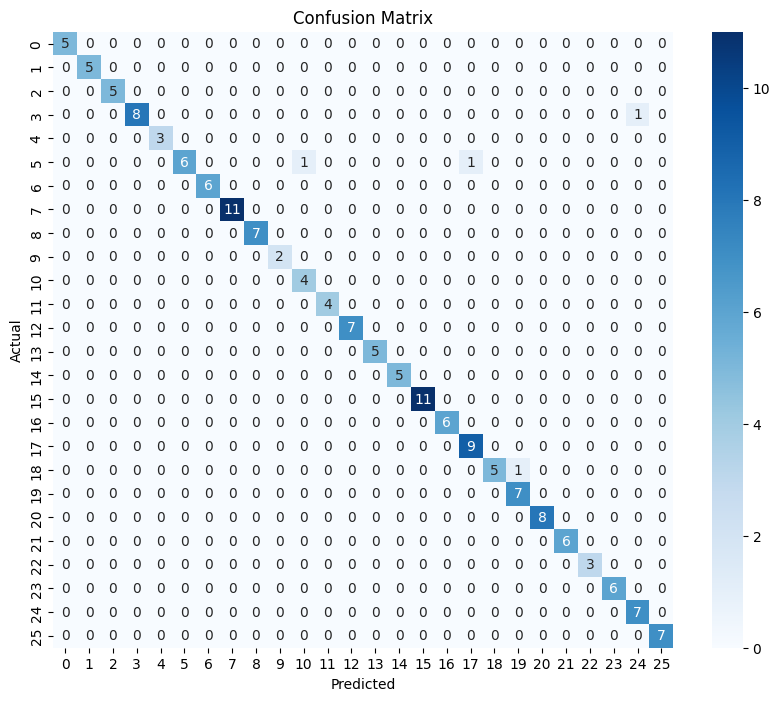

In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [14]:
model.save('/content/drive/MyDrive/AZ_CNN_model.keras')  # Save to Drive


In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img = load_img('/content/drive/MyDrive/resized_Image/D/1.png', target_size=(64,64), color_mode='grayscale')
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

print("Predicted Label:", le.inverse_transform([predicted_class])[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label: D


In [21]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/AZ_CNN_model.keras')
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img = load_img('/content/drive/MyDrive/resized_Image/B/10.png', target_size=(64, 64), color_mode='grayscale')
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# If you used LabelEncoder before:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.classes_ = np.array(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))  # Recreate class labels if needed

print("Predicted letter:", le.inverse_transform([predicted_class])[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted letter: B


In [22]:
!pip install gradio


In [23]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from sklearn.preprocessing import LabelEncoder

model = load_model('/content/drive/MyDrive/AZ_CNN_model.keras')

le = LabelEncoder()
le.classes_ = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))

def predict_letter(image):
    image = image.convert('L').resize((64, 64))  # Grayscale and resize
    img_array = img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred)
    return le.inverse_transform([predicted_class])[0]

iface = gr.Interface(fn=predict_letter,
                     inputs=gr.Image(type="pil"),
                     outputs="text",
                     title="A–Z Character Classifier")

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e247607842dfa2f0c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [24]:
!git config --global user.name "Shifaliii"
!git config --global user.email "shifalilobo9@gmail.com"


In [26]:
!git clone https://github.com/Shifaliii/az-cnn-classifier.git


Cloning into 'az-cnn-classifier'...


In [32]:
!ls /content




az-cnn-classifier  drive  sample_data
